In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [2]:
train_x=[]
for i in range(1,202599):
    x=str(i)
    print(i/202599)
    while len(x)!=6:
        x="0"+x
    temp="D:/Data Science course works/Destation/Celeb_A_DATA/img_align_celeba/img_align_celeba/"+x+".jpg"
    temp=cv2.imread(temp,1)
    temp = cv2.cvtColor(temp, cv2.COLOR_BGR2RGB)
    temp=cv2.resize(temp,(64,64),interpolation = cv2.INTER_AREA)
    train_x.append(temp.astype('float32')/255.0)
train_x=np.array(train_x)

03354
0.994772925828854
0.9947778616873726
0.9947827975458912
0.9947877334044097
0.9947926692629282
0.9947976051214468
0.9948025409799653
0.9948074768384839
0.9948124126970025
0.994817348555521
0.9948222844140395
0.9948272202725581
0.9948321561310767
0.9948370919895952
0.9948420278481137
0.9948469637066323
0.9948518995651509
0.9948568354236694
0.994861771282188
0.9948667071407066
0.994871642999225
0.9948765788577436
0.9948815147162622
0.9948864505747808
0.9948913864332993
0.9948963222918178
0.9949012581503364
0.9949061940088549
0.9949111298673735
0.9949160657258921
0.9949210015844105
0.9949259374429291
0.9949308733014477
0.9949358091599663
0.9949407450184848
0.9949456808770033
0.9949506167355219
0.9949555525940404
0.994960488452559
0.9949654243110776
0.9949703601695961
0.9949752960281146
0.9949802318866332
0.9949851677451518
0.9949901036036704
0.9949950394621888
0.9949999753207074
0.995004911179226
0.9950098470377445
0.9950147828962631
0.9950197187547816
0.9950246546133001
0.9950295904

(64, 64, 3)


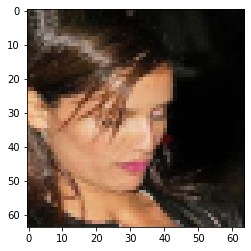

In [3]:
print(train_x[0].shape)
plt.imshow(train_x[3])

In [4]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
latent_dim = 40

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
shape = keras.backend.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 16, 16, 64)   18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 16384)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

In [6]:
print(shape)

(None, 16, 16, 64)


In [7]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(shape[1]*shape[2]*shape[3], activation="relu")(latent_inputs)
x = layers.Reshape((shape[1],shape[2],shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense_1 (Dense)              (None, 16384)             671744    
_________________________________________________________________
reshape (Reshape)            (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 64, 64, 3)         867       
Total params: 728,003
Trainable params: 728,003
Non-trainable params: 0
_____________________________________________________

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


In [9]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train_x, epochs=30, batch_size=128)

Epoch 1/30
1583/1583 [==============================] - 560s 354ms/step - loss: 2741.1383 - reconstruction_loss: 2731.9368 - kl_loss: 0.0235
Epoch 2/30
1583/1583 [==============================] - 582s 368ms/step - loss: 2727.4261 - reconstruction_loss: 2727.4612 - kl_loss: 0.0186
Epoch 3/30
1583/1583 [==============================] - 659s 416ms/step - loss: 2727.1039 - reconstruction_loss: 2727.0305 - kl_loss: 0.0089
Epoch 4/30
1583/1583 [==============================] - 732s 462ms/step - loss: 2727.0238 - reconstruction_loss: 2726.8423 - kl_loss: 0.0055
Epoch 5/30
1583/1583 [==============================] - 635s 401ms/step - loss: 2727.0600 - reconstruction_loss: 2726.6772 - kl_loss: 0.0037
Epoch 6/30
1583/1583 [==============================] - 608s 384ms/step - loss: 2726.5728 - reconstruction_loss: 2726.6079 - kl_loss: 0.0028
Epoch 7/30
1583/1583 [==============================] - 597s 377ms/step - loss: 2727.0316 - reconstruction_loss: 2726.5957 - kl_loss: 0.0025
Epoch 8/30
15

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


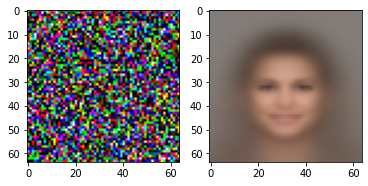

In [10]:
gen = np.random.normal(size = (1,64,64,3))
gen_sample = vae.encoder.predict(gen)
gen_sample=vae.decoder.predict(gen_sample)
plt.subplot(1,2,1)
plt.imshow(gen[0])
plt.subplot(1,2,2)
plt.imshow(gen_sample[0])

In [11]:
vae.encoder.save_weights('celeb_a_encoder.h5')
vae.decoder.save_weights('celeb_a_decoder.h5')

In [12]:
latent_dim = 40

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
shape = keras.backend.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder_1 = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder_1.summary()
encoder_1.load_weights('celeb_a_encoder.h5')

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   896         input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 16384)        0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [13]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(shape[1]*shape[2]*shape[3], activation="relu")(latent_inputs)
x = layers.Reshape((shape[1],shape[2],shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder_1 = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder_1.summary()
decoder_1.load_weights('celeb_a_decoder.h5')

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 40)]              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16384)             671744    
_________________________________________________________________
reshape_1 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_4 (Conv2DTr (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_5 (Conv2DTr (None, 64, 64, 3)         867       
Total params: 728,003
Trainable params: 728,003
Non-trainable params: 0
_____________________________________________________

In [14]:
vae = VAE(encoder_1, decoder_1)
vae.compile(optimizer=keras.optimizers.Adam())

[[ 0.44599777 -0.13521494 -0.70380036 -0.98024469 -0.47530911 -0.6372449
  -0.13257829  1.15265163 -0.64337244  0.96471991  0.94164589  0.18136116
  -0.0589673  -1.23165957 -1.79986585 -0.94768254 -0.15747534 -0.09374065
   1.40816449  1.87174669  1.16459467 -0.35745744  0.35009139  0.16516853
   0.529465    0.06670291  1.488234   -2.1213037   0.15141309 -0.78502166
  -2.11679651 -0.21528363  0.27809046 -0.26800486 -0.27703033 -0.12348113
  -1.78541772  0.36600691 -0.01798122 -0.91566874]]


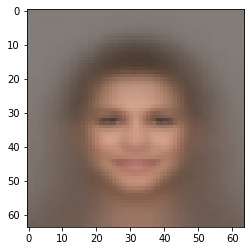

In [15]:
gen = np.random.normal(size = (1,40))
print(gen)
gen_sample=vae.decoder.predict(gen)
plt.imshow(gen_sample[0])

[[-1.19236498e+00  2.40697749e-01  1.74271809e+00 -7.14502026e-02
   1.46092461e+00 -9.34497511e-01 -1.57832461e-01  1.67133753e-01
  -8.30753045e-01 -2.03163732e-01 -1.58072329e-01  6.63701784e-01
  -7.03562944e-02  2.58994722e-01  6.64824275e-01  1.27879213e+00
  -1.61033143e+00 -2.62253890e-01 -1.39469148e+00  3.49936212e-01
   3.39526915e-01  1.69096543e-01  1.61910882e-03 -6.55004543e-01
  -3.04652189e-01  6.69333972e-01  7.89824633e-01  2.43588714e+00
   4.14442364e-01 -1.11851286e+00  1.64878571e+00 -2.36027443e-01
  -5.54399786e-01  6.48301891e-02 -2.57349709e-01 -3.80059431e-01
  -7.65495713e-01 -1.33258286e+00 -1.67856914e-01  4.78081431e-01]]


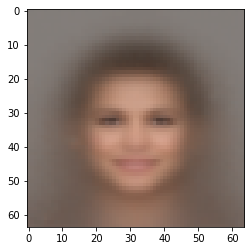

In [16]:
gen = np.random.normal(size = (1,40))
print(gen)
gen_sample=vae.decoder.predict(gen)
plt.imshow(gen_sample[0])

[[[[0.90588236 0.8901961  0.95686275]
   [0.90588236 0.8901961  0.95686275]
   [0.90588236 0.8901961  0.95686275]
   ...
   [0.9137255  0.8784314  0.9529412 ]
   [0.91764706 0.88235295 0.95686275]
   [0.92156863 0.8862745  0.9607843 ]]

  [[0.8980392  0.88235295 0.9490196 ]
   [0.8980392  0.88235295 0.9490196 ]
   [0.9019608  0.8862745  0.9529412 ]
   ...
   [0.9137255  0.8784314  0.9529412 ]
   [0.91764706 0.88235295 0.95686275]
   [0.92156863 0.8862745  0.9607843 ]]

  [[0.89411765 0.8784314  0.94509804]
   [0.89411765 0.8784314  0.94509804]
   [0.8980392  0.88235295 0.9490196 ]
   ...
   [0.9137255  0.8784314  0.9529412 ]
   [0.92156863 0.8862745  0.9607843 ]
   [0.9254902  0.8901961  0.9647059 ]]

  ...

  [[0.27450982 0.13333334 0.2       ]
   [0.45882353 0.27450982 0.3019608 ]
   [0.7254902  0.49803922 0.49411765]
   ...
   [0.21568628 0.14901961 0.19215687]
   [0.3647059  0.29803923 0.3372549 ]
   [0.6745098  0.6156863  0.654902  ]]

  [[0.23529412 0.13333334 0.23137255]
   [0.3

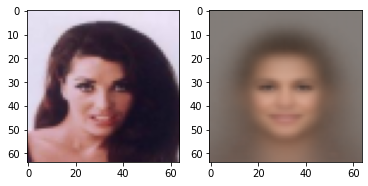

In [28]:
a=train_x[10:11]
print(a)
gen_sample = vae.encoder.predict(a)
gen_sample=vae.decoder.predict(gen_sample)
plt.subplot(1,2,1)
plt.imshow(a[0])
plt.subplot(1,2,2)
plt.imshow(gen_sample[0])

In [9]:
latent_dim = 256

encoder_inputs = keras.Input(shape=(64, 64, 3))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
shape = keras.backend.int_shape(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
x = layers.Dense(32, activation="relu")(x)
x = layers.Dense(64, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 32, 32, 32)   896         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 16, 16, 64)   18496       conv2d_2[0][0]                   
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 16384)        0           conv2d_3[0][0]                   
____________________________________________________________________________________________

In [11]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(shape[1]*shape[2]*shape[3], activation="relu")(latent_inputs)
x = layers.Reshape((shape[1],shape[2],shape[3]))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)
decoder_1 = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder_1.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 256)]             0         
_________________________________________________________________
dense_7 (Dense)              (None, 16384)             4210688   
_________________________________________________________________
reshape_3 (Reshape)          (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_transpose_9 (Conv2DTr (None, 32, 32, 64)        36928     
_________________________________________________________________
conv2d_transpose_10 (Conv2DT (None, 64, 64, 32)        18464     
_________________________________________________________________
conv2d_transpose_11 (Conv2DT (None, 64, 64, 3)         867       
Total params: 4,266,947
Trainable params: 4,266,947
Non-trainable params: 0
_________________________________________________

In [14]:
vae = VAE(encoder, decoder_1)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(train_x, epochs=50, batch_size=128)

NameError: name 'encoder_1' is not defined

In [ ]:
gen = np.random.normal(size = (1,256))
print(gen)
gen_sample=vae.decoder.predict(gen)
plt.imshow(gen_sample[0])

In [ ]:
vae.encoder.save_weights('celeb_a_256_encoder.h5')
vae.decoder.save_weights('celeb_a_256_decoder.h5')